In [14]:
#This script runs a transient simulation of the CO2 methanation in a Berty (CSTR) reactor.
#For details on the setup and the model refer to the following publication 
#https://doi.org/10.1002/cctc.202200570

#The feed is alternated between a mixture of H2/Ar and CO2/He

import cantera as ct
import numpy as np
import pandas as pd

#Parameters for the Berty reactor
vol=98e-6
cat_area_per_vol = 1.1198/vol  # Catalyst particle surface area 
cat_area = cat_area_per_vol * vol
sccm = 395*1e-6/60

#Flow rates
V_purge=95

#Calculate the H2/Ar stream
V_Ar=210
V_H2=90

V1_ges=V_purge+V_H2+V_Ar
x_Ar_1=(V_Ar+V_purge)/V1_ges
x_H2_1=V_H2/V1_ges

#Calculate the H2/Ar stream
V_He=210
V_CO2=90
V2_ges=V_purge+V_He+V_CO2
x_Ar_2=V_purge/V2_ges
x_He_2=V_He/V2_ges
x_CO2_2=V_CO2/V2_ges

n_runs=5000
offset=0

def methanation(t,p):
        T=t+273.15 #temperature
        pressure=p*1e5 #pressure of the CSTR

        file='mechanism.yaml'
        cti_file = file

        #The CSTR setup in Cantera is quite straightforward
        gas = ct.Solution(cti_file, 'gas')
        gas.TPX = T, pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'
        # import the surface model
        surf = ct.Interface(cti_file,'surface1', [gas])
        surf.TP = T, pressure
        surf.coverages = {'site(7)':1}

        upstream = ct.Reservoir(gas, name='upstream')
        downstream = ct.Reservoir(gas, name='downstream')
        r=ct.IdealGasReactor(gas, energy='off')

        r.volume = vol
        rsurf=ct.ReactorSurface(surf, r, A=cat_area)

        mass_flow=sccm* gas.mean_molecular_weight*1e5/ct.gas_constant/273.15

        mflow = ct.MassFlowController(upstream, r, mdot=mass_flow)
        v = ct.PressureController(r, downstream, master=mflow, K=1e-9)
        sim=ct.ReactorNet([r])

        ##set relative and absolute tolerances on the simulation
        sim.rtol = 1.0e-12
        sim.atol = 1.0e-26
        sim.max_err_test_fails = 100
        time_lag=16 #empirical parameter to align the internal standards. Lag is caused
# by switching time, residence time in the pipes and stuff

        rxn_time=np.linspace(0,1050+time_lag,1051+time_lag)

        gas_mole_fracs=np.zeros([gas.n_species, len(rxn_time)])
        surf_fracs=np.zeros([surf.n_species, len(rxn_time)])

        for i in range(len(rxn_time)):
            time=rxn_time[i]
            #Switch manually the inlet concentration between both feeds
            if time < 180+time_lag:
                upstream.thermo.TPX=T,pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'
            elif (time >= 180+time_lag) and (time < 240+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.2405, He:0.5316, Ne:0.0, CO2(2):0.2278,  H2(4):0'
            elif (time >= 240+time_lag) and (time < 300+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'
            elif (time >= 300+time_lag) and (time < 360+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.2405, He:0.5316, Ne:0.0, CO2(2):0.2278,  H2(4):0'
            elif (time >= 360+time_lag) and (time < 420+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'
            elif (time >= 420+time_lag) and (time < 480+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.2405, He:0.5316, Ne:0.0, CO2(2):0.2278,  H2(4):0'
            elif (time >= 480+time_lag) and (time < 540+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'
            elif (time >= 540+time_lag) and (time < 600+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.2405, He:0.5316, Ne:0.0, CO2(2):0.2278,  H2(4):0'
            elif (time >= 600+time_lag) and (time < 660+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'
            elif (time >= 660+time_lag) and (time < 720+time_lag):
                upstream.thermo.TPX=T,pressure, 'Ar:0.2405, He:0.5316, Ne:0.0, CO2(2):0.2278,  H2(4):0'
            else:
                upstream.thermo.TPX=T,pressure, 'Ar:0.7722, He:0, Ne:0.0, CO2(2):0,  H2(4):0.2278'

            upstream.syncState()
            #The volumetric flow rate is the same but the mass flow changes
            mass_flow=sccm* upstream.thermo.mean_molecular_weight*1e5/ct.gas_constant/273.15
            mflow.mass_flow_rate=mass_flow
            sim.reinitialize()
            sim.advance(time)
            #store the results
            gas_mole_fracs[:,i]=np.round(gas.X,7)
            surf_fracs[:,i]=np.round(surf.X,7)
            
        output_filename='results.txt'
        data=np.c_[rxn_time,gas_mole_fracs.T,surf_fracs.T]
        names=list(['Time'] + gas.species_names+surf.species_names)
        df=pd.DataFrame(data, columns=[names])
        df.to_csv(output_filename, index=False)

            
#Provide the temperature in °C and the pressure in bar.
methanation(350, 5)

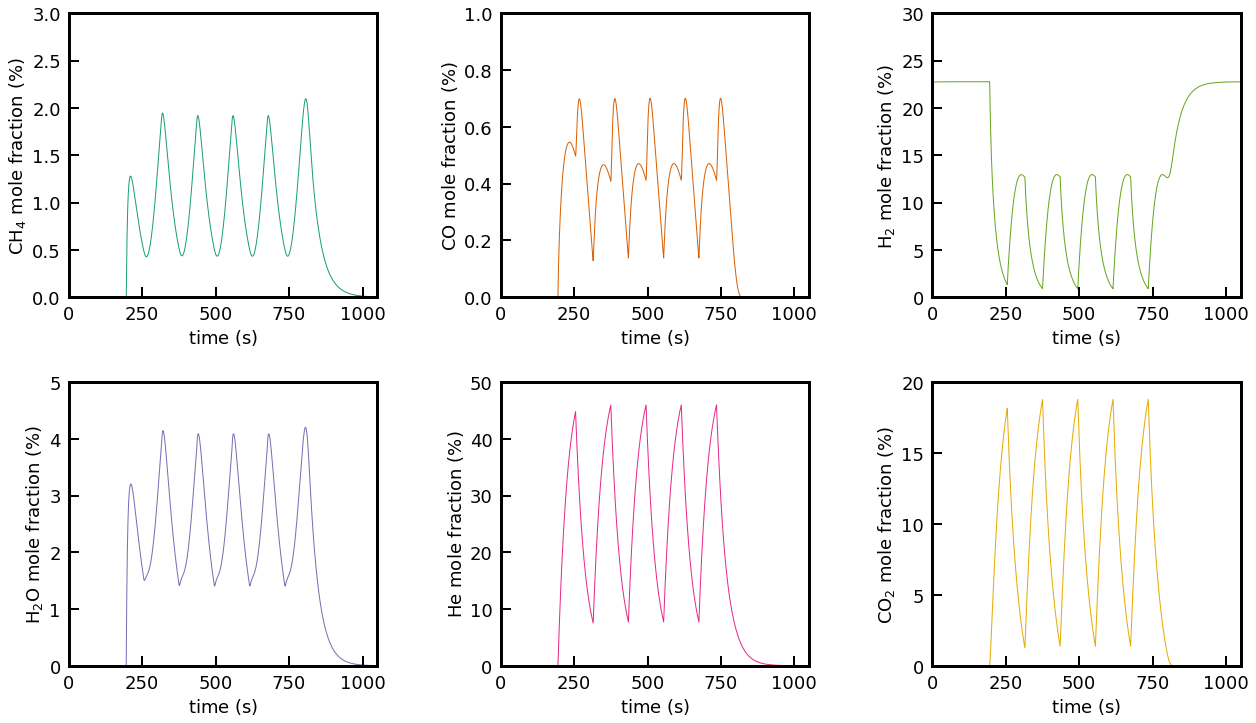

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize']=(21,12)
plt.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=16)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.major.width']=2
plt.rcParams['legend.edgecolor']='k'
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['axes.axisbelow']=False
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['legend.handletextpad']=0.2
plt.rcParams['legend.columnspacing']=2
plt.rcParams['legend.labelspacing']=0.5

colormap=plt.cm.Dark2
colors = [colormap(i) for i in np.linspace(0, 1, 8)]

gs=gridspec.GridSpec(nrows=2, ncols=3)
gs.update(wspace=0.4, hspace=0.3)

ax0=plt.subplot(gs[0,0])
ax1=plt.subplot(gs[0,1])
ax2=plt.subplot(gs[1,0])
ax3=plt.subplot(gs[1,1])

ax4=plt.subplot(gs[0,2])
ax5=plt.subplot(gs[1,2])

#Open the simulation results
sim=pd.read_csv('results.txt', sep=",", header=0)

ax0.plot(sim['Time'], sim['CH4(1)']*100,  color=colors[0], linewidth=1)
ax1.plot(sim['Time'], sim['CO(5)']*100,  color=colors[1], linewidth=1)
ax2.plot(sim['Time'], sim['H2O(3)']*100,  color=colors[2], linewidth=1)
ax3.plot(sim['Time'], sim['He']*100,  color=colors[3], linewidth=1)
ax4.plot(sim['Time'], sim['H2(4)']*100,  color=colors[4], linewidth=1)
ax5.plot(sim['Time'], sim['CO2(2)']*100,  color=colors[5], linewidth=1)


ax0.set_xlabel('$\mathrm{time\ (s)}$')
ax0.set_xlim([0, 1050])
ax0.set_ylim([0, 3])
ax0.set_ylabel('$\mathrm{CH_4\ mole\ fraction\ (\%)}$')

ax1.set_xlabel('$\mathrm{time\ (s)}$')
ax1.set_xlim([0, 1050])
ax1.set_ylim([0, 1])
ax1.set_ylabel('$\mathrm{CO\ mole\ fraction\ (\%)}$')

ax2.set_xlabel('$\mathrm{time\ (s)}$')
ax2.set_xlim([0, 1050])
ax2.set_ylim([0, 5])
ax2.set_ylabel('$\mathrm{H_2O\ mole\ fraction\ (\%)}$')

ax3.set_xlabel('$\mathrm{time\ (s)}$')
ax3.set_xlim([0, 1050])
ax3.set_ylim([0, 50])
ax3.set_ylabel('$\mathrm{He\ mole\ fraction\ (\%)}$')

ax4.set_xlabel('$\mathrm{time\ (s)}$')
ax4.set_xlim([0, 1050])
ax4.set_ylim([0, 30])
ax4.set_ylabel('$\mathrm{H_2\ mole\ fraction\ (\%)}$')

ax5.set_xlabel('$\mathrm{time\ (s)}$')
ax5.set_xlim([0, 1050])
ax5.set_ylim([0, 20])
ax5.set_ylabel('$\mathrm{CO_2\ mole\ fraction\ (\%)}$')

plt.show()